### **Simulation**

{'health': 0.012195121951219513, 'news': 0.6585365853658537, 'sports': 0.036585365853658534, 'weather': 0.036585365853658534, 'entertainment': 0.0, 'autos': 0.0, 'lifestyle': 0.06097560975609756, 'travel': 0.06097560975609756, 'foodanddrink': 0.036585365853658534, 'tv': 0.0, 'finance': 0.06097560975609756, 'movies': 0.012195121951219513, 'video': 0.012195121951219513, 'music': 0.012195121951219513, 'kids': 0.0, 'middleeast': 0.0, 'northamerica': 0.0}


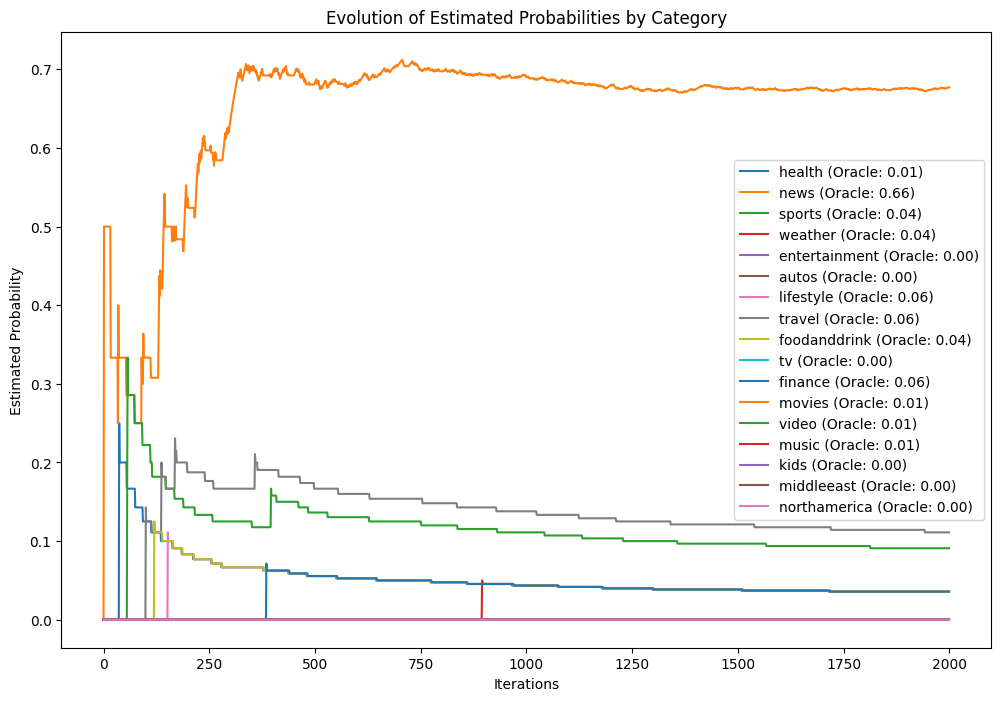

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select a specific user and analyze their history
user_id = 'U91836'
user_history = behaviors[behaviors['UserID'] == user_id]['ClickHistory'].iloc[0].split()

# Count categories in user history
category_counts_history = {cat: 0 for cat in news['Category'].unique()}
for news_id in user_history:
    category = news[news['NewsID'] == news_id]['Category'].iloc[0]
    category_counts_history[category] += 1

# Calculate oracle probabilities based on user history
total_clicks = sum(category_counts_history.values())
oracle_probs = {cat: category_counts_history[cat] / total_clicks for cat in news['Category'].unique()}
print(oracle_probs)
# UCB Initialization
category_counts = {cat: 1 for cat in news['Category'].unique()}
category_rewards = {cat: 0.0 for cat in news['Category'].unique()}

def simulate_user_feedback(category):
    """Simulate user feedback based on oracle probability."""
    return np.random.rand() < oracle_probs[category]

def update_scores(news_id, liked):
    category = news[news['NewsID'] == news_id]['Category'].iloc[0]
    category_counts[category] += 1
    if liked:
        category_rewards[category] += 1

# Arrays to hold score evolution for visualization
evolution = {cat: [] for cat in news['Category'].unique()}

# Simulation loop
for _ in range(2000):
    total_selections = sum(category_counts.values())
    category_ucb = {}
    
    for cat in news['Category'].unique():
        average_reward = category_rewards[cat] / category_counts[cat]
        confidence = np.sqrt((2 * np.log(total_selections)) / category_counts[cat])
        category_ucb[cat] = average_reward + confidence

    # Select and simulate feedback
    selected_category = max(category_ucb, key=category_ucb.get)
    liked = simulate_user_feedback(selected_category)
    recommended_news = news[news['Category'] == selected_category].sample(1)
    update_scores(recommended_news.iloc[0]['NewsID'], liked)
    
    # Record scores
    for cat in news['Category'].unique():
        avg_reward = category_rewards[cat] / category_counts[cat]
        evolution[cat].append(avg_reward)

# Plotting
plt.figure(figsize=(12, 8))
for cat in news['Category'].unique():
    plt.plot(evolution[cat], label=f'{cat} (Oracle: {oracle_probs[cat]:.2f})')

plt.title('Evolution of Estimated Probabilities by Category')
plt.xlabel('Iterations')
plt.ylabel('Estimated Probability')
plt.legend()
plt.show()

### **Recommendations**

In [21]:
import pandas as pd
import numpy as np

# Step 1: Load datasets
news = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/news.tsv', sep='\t', names=["NewsID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"])
behaviors = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/behaviors.tsv', sep='\t', names=["impressionId", "UserID", "timestamp", "ClickHistory", "impression"])

# Step 2: Initialize UCB scores
categories = news['Category'].unique()
category_counts = {cat: 1 for cat in categories}  # Count of selections for each category
category_rewards = {cat: 0.0 for cat in categories}  # Sum of rewards for each category

# Fetch user data
user_id = 'U91836'
user_history = behaviors[behaviors['UserID'] == user_id]['ClickHistory'].iloc[0].split()

# Initialize based on user history
user_category_counts = {}
for news_id in user_history:
    category = news[news['NewsID'] == news_id]['Category'].iloc[0]
    category_rewards[category] += 1  # Increment the reward for categories user has clicked
    category_counts[category] += 1
    if category in user_category_counts:
        user_category_counts[category] += 1
    else:
        user_category_counts[category] = 1

# Function to recommend articles
def recommend_article():
    total_selections = sum(category_counts.values())
    category_ucb = {}
    for cat in categories:
        average_reward = category_rewards[cat] / category_counts[cat]
        confidence = np.sqrt((2 * np.log(total_selections)) / category_counts[cat])
        category_ucb[cat] = average_reward + confidence

    # Select the category with the highest UCB score
    selected_category = max(category_ucb, key=category_ucb.get)
    
    # Recommend a random article from the selected category
    recommended_news = news[news['Category'] == selected_category].sample(1)
    return recommended_news.iloc[0]['NewsID'], recommended_news.iloc[0]['Title'], selected_category

def update_scores(news_id, liked):
    category = news[news['NewsID'] == news_id]['Category'].iloc[0]
    category_counts[category] += 1
    if liked:
        category_rewards[category] += 1

# Simulate the recommendation and feedback loop
recommended_news_ids = []
for _ in range(5):  # Simulate 5 rounds of recommendation and feedback
    news_id, title, category = recommend_article()
    print(f"Recommended: {title} (News ID: {news_id}) - Category: {category}")
    update_scores(news_id, 'yes')
    recommended_news_ids.append(news_id)

# Update behaviors dataframe
new_click_history = ' '.join(user_history + recommended_news_ids)
behaviors.loc[behaviors['UserID'] == user_id, 'ClickHistory'] = new_click_history

# Sort and print top 5 user categories
top_user_categories = sorted(user_category_counts.items(), key=lambda item: item[1], reverse=True)[:5]
print("Top 5 User Categories from History:", [cat for cat, count in top_user_categories])

# Print the recommended categories
print("Categories Recommended:", [news[news['NewsID'] == id]['Category'].iloc[0] for id in recommended_news_ids])

# Show updated user behavior
print("Updated Click History for User:", new_click_history)


Recommended: All the Ways the Motherless Brooklyn Movie Departs From Jonathan Lethem's Novel (News ID: N50581) - Category: entertainment
Recommended: The McLaren Senna is Faster 0-100-0 Than These Fast Cars Are 0-100 (News ID: N38505) - Category: autos
Recommended: 'Supernatural' star arrested for multiple altercations in Texas (News ID: N48284) - Category: tv
Recommended: Strange disease threatens Caribbean coral reef (News ID: N44039) - Category: kids
Recommended: Saudi says Baghdadi 'distorted' image of Islam, praises killing (News ID: N54746) - Category: middleeast
Top 5 User Categories from History: ['news', 'finance', 'travel', 'lifestyle', 'sports']
Categories Recommended: ['entertainment', 'autos', 'tv', 'kids', 'middleeast']
Updated Click History for User: N31739 N6072 N63045 N23979 N35656 N43353 N8129 N1569 N17686 N13008 N21623 N6233 N14340 N48031 N62285 N44383 N23061 N16290 N6244 N45099 N58715 N59049 N7023 N50528 N42704 N46082 N8275 N15710 N59026 N8429 N30867 N56514 N19709 N

### **Metrics**

In [32]:
import pandas as pd
import numpy as np

news = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/news.tsv', sep='\t', names=["NewsID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"])
behaviors = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/behaviors.tsv', sep='\t', names=["impressionId", "UserID", "timestamp", "ClickHistory", "impression"])

def run_simulation():
    # Initialize UCB scores
    categories = news['Category'].unique()
    category_counts = {cat: 1 for cat in categories}
    category_rewards = {cat: 0.0 for cat in categories}

    # Fetch user data
    user_id = 'U8125'
    user_history = behaviors[behaviors['UserID'] == user_id]['ClickHistory'].iloc[0].split()
    user_category_counts = {}
    
    # Initialize based on user history
    for news_id in user_history:
        category = news[news['NewsID'] == news_id]['Category'].iloc[0]
        category_rewards[category] += 1
        category_counts[category] += 1
        if category in user_category_counts:
            user_category_counts[category] += 1
        else:
            user_category_counts[category] = 1

    def recommend_article():
        total_selections = sum(category_counts.values())
        category_ucb = {}
        for cat in categories:
            average_reward = category_rewards[cat] / category_counts[cat]
            confidence = np.sqrt((2 * np.log(total_selections)) / category_counts[cat])
            category_ucb[cat] = average_reward + confidence
        selected_category = max(category_ucb, key=category_ucb.get)
        recommended_news = news[news['Category'] == selected_category].sample(1)
        return recommended_news.iloc[0]['NewsID'], recommended_news.iloc[0]['Title'], selected_category

    def update_scores(news_id, liked):
        category = news[news['NewsID'] == news_id]['Category'].iloc[0]
        category_counts[category] += 1
        if liked:
            category_rewards[category] += 1

    recommended_news_ids = []
    for _ in range(5):
        news_id, title, category = recommend_article()
        update_scores(news_id, 'yes')
        recommended_news_ids.append(news_id)

    new_click_history = ' '.join(user_history + recommended_news_ids)
    behaviors.loc[behaviors['UserID'] == user_id, 'ClickHistory'] = new_click_history
    
    top_user_categories = sorted(user_category_counts.items(), key=lambda item: item[1], reverse=True)[:5]
    top_user_categories = [cat for cat, count in top_user_categories]
    recommended_categories = [news[news['NewsID'] == id]['Category'].iloc[0] for id in recommended_news_ids]

    # Calculate Match Rate and Coverage
    match_rate = len(set(recommended_categories) & set(top_user_categories)) / len(recommended_categories)
    coverage = len(set(recommended_categories) & set(top_user_categories)) / len(top_user_categories)

#     print("Top 5 User Categories from History:", top_user_categories)
#     print("Categories Recommended:", recommended_categories)
    print("Match Rate:", match_rate)
    print("Coverage:", coverage)
    return match_rate, coverage

match_rates = []
coverages = []

# Run the simulation 10 times
for i in range(20):
    print(f"Run {i+1}:")
    match_rate, coverage = run_simulation()
    match_rates.append(match_rate)
    coverages.append(coverage)
    print("\n")

# Calculate the mean of each list
average_match_rate = sum(match_rates) / len(match_rates)
average_coverage = sum(coverages) / len(coverages)

# Print the means
print("Mean Match Rate:", average_match_rate)
print("Mean Coverage:", average_coverage)

Run 1:
Match Rate: 0.0
Coverage: 0.0


Run 2:
Match Rate: 0.0
Coverage: 0.0


Run 3:
Match Rate: 0.4
Coverage: 0.4


Run 4:
Match Rate: 0.4
Coverage: 0.4


Run 5:
Match Rate: 0.0
Coverage: 0.0


Run 6:
Match Rate: 0.0
Coverage: 0.0


Run 7:
Match Rate: 0.6
Coverage: 0.6


Run 8:
Match Rate: 0.0
Coverage: 0.0


Run 9:
Match Rate: 0.0
Coverage: 0.0


Run 10:
Match Rate: 0.4
Coverage: 0.4


Run 11:
Match Rate: 0.4
Coverage: 0.4


Run 12:
Match Rate: 0.0
Coverage: 0.0


Run 13:
Match Rate: 0.2
Coverage: 0.2


Run 14:
Match Rate: 0.4
Coverage: 0.4


Run 15:
Match Rate: 0.0
Coverage: 0.0


Run 16:
Match Rate: 0.0
Coverage: 0.0


Run 17:
Match Rate: 0.4
Coverage: 0.4


Run 18:
Match Rate: 0.2
Coverage: 0.2


Run 19:
Match Rate: 0.0
Coverage: 0.0


Run 20:
Match Rate: 0.4
Coverage: 0.4


Mean Match Rate: 0.19
Mean Coverage: 0.19
